# Implementation: Linear Regression

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

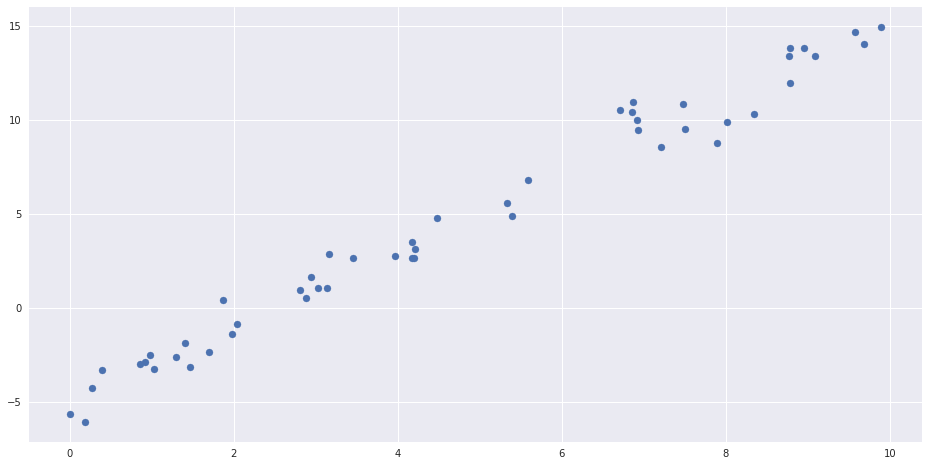

In [191]:
rng = np.random.RandomState(1)
x_train = 10 * rng.rand(50)
y_train = 2 * x_train - 5 + rng.randn(50)
plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train);

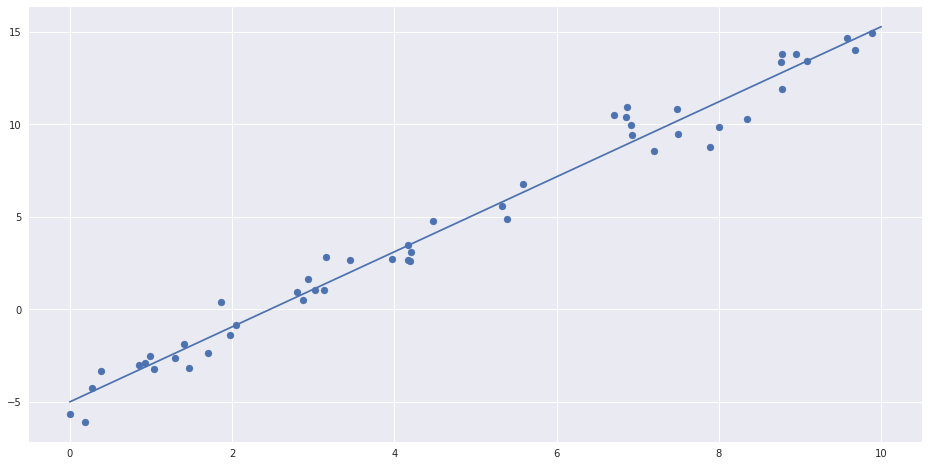

In [192]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x_train[:, np.newaxis], y_train)

x_test = np.linspace(0, 10, 1000)
y_estimated = model.predict(x_test[:, np.newaxis])

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, y_estimated);

In [193]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.02720881036
Model intercept: -4.99857708555


In [194]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


## Basis Function Regression

To adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.


The idea is to take multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

$$\text{We let   } x_n = f_n(x) \text{  , where    } f_n(x)  \text{  is some function that transforms our data.  }$$


take our one-dimensional $x$ values and projected them into a higher dimension

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$



### Polynomial basis functions


In [195]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [196]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

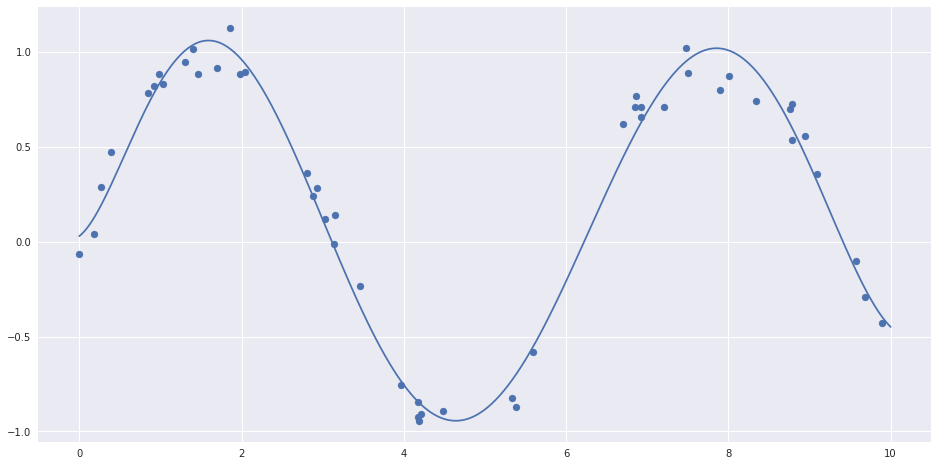

In [197]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.figure(figsize=(16,8))
plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian basis functions


For example, one useful pattern is to fit a model that is a sum of Gaussian bases.


(-1.5, 1.5)

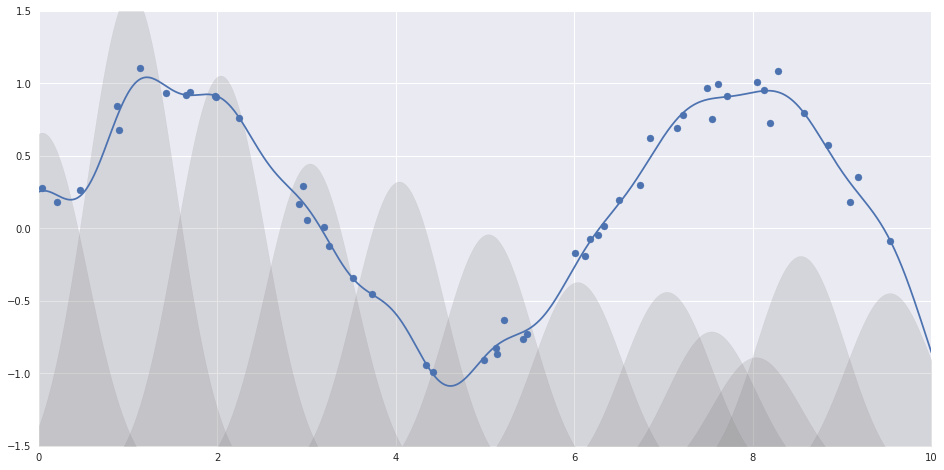

In [198]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt


class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, order, width_factor=2.0):
        self.order=order
        self.stddev_factor=width_factor

    def gaussian_basis(self, x, y, stddev, axis= None):
        arg = (x - y) / stddev
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y): # make it private
        self.mu=np.linspace(X.min(), X.max(), self.order)
        self.stddev=self.stddev_factor*(self.mu[1]-self.mu[0])
        return self

    def transform(self, X):
        return self.gaussian_basis(X[:,:, np.newaxis], self.mu, self.stddev, axis=1)

rs=np.random.RandomState(10)
order=20

x_train=10*rs.rand(50)
y_train=np.sin(x_train)+0.1*rs.randn(50) # add white noise

x_test = np.linspace(0, 10, 1000)

gauss_model = make_pipeline(GaussianFeatures(order, 1.0),
                            LinearRegression())

gauss_model.fit(x_train[:, np.newaxis], y_train)


y_estimated=gauss_model.predict(x_test[:, np.newaxis])

gf=gauss_model.named_steps['gaussianfeatures']
lr=gauss_model.named_steps['linearregression']

fig, ax=plt.subplots(figsize=(16,8))

for i in range(order):
    encoder = np.zeros(order)
    encoder[i] = 1
    X_test = gf.transform(x_test[:, None]) * encoder
    Y_estimated=lr.predict(X_test)
    ax.fill_between(x_test, Y_estimated.min(), Y_estimated, color='gray', alpha=0.2)

ax.scatter(x_train,y_train)
ax.plot(x_test,y_estimated)

ax.set_xlim(0,10)
ax.set_ylim(-1.5, 1.5)


__The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.__


## Regularization

Basis functions makes the model much more flexible, but it also can very quickly lead to over-fitting:

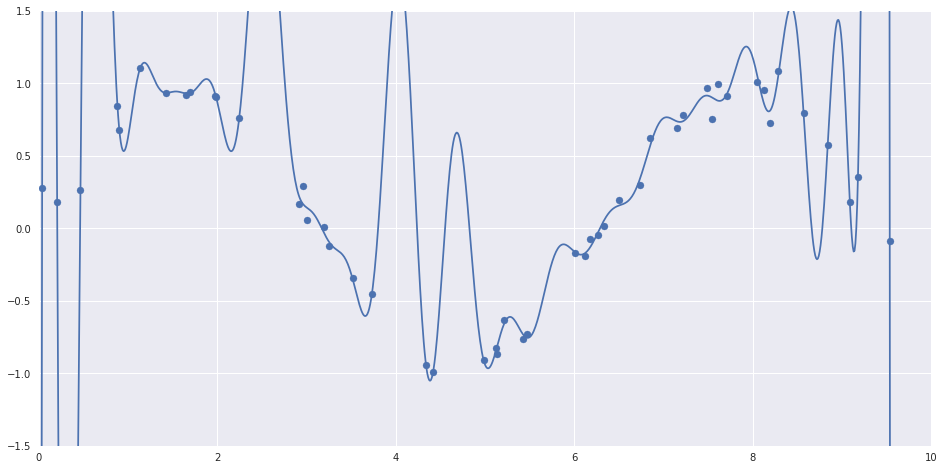

In [199]:
model = make_pipeline(GaussianFeatures(40),
                      LinearRegression())
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

### Ridge regression (L2 Regularization)

The most common form of regularization is known as *ridge regression* or L2 *regularization*.

penalizing the sum of squares (2-norms) of the model coefficients

in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$


__where alpha is a free parameter that controls the strength of the penalty.__


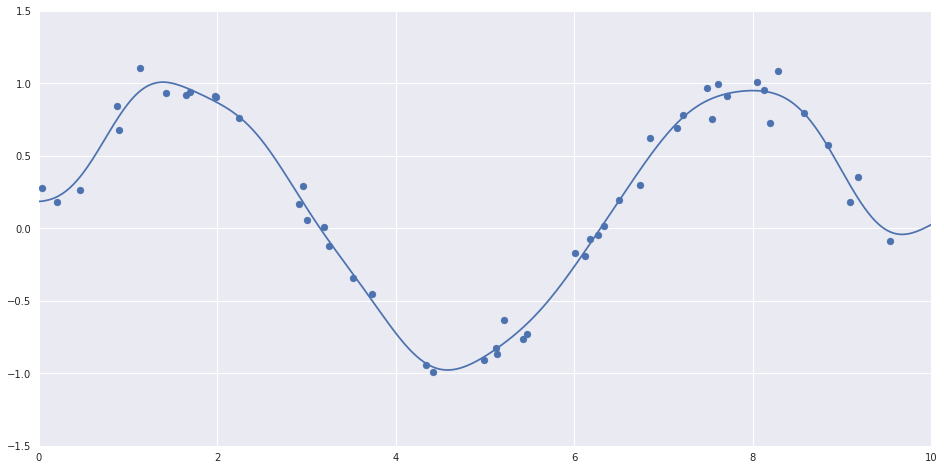

In [200]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(40), Ridge(alpha=0.1))
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

$$ \text{ The  } \alpha \text{   parameter is essentially controlling the complexity of the resulting model.}$$



One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression (L1 regularization)


$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Due to geometric reasons lasso regression tends to favor **sparse models** where possible

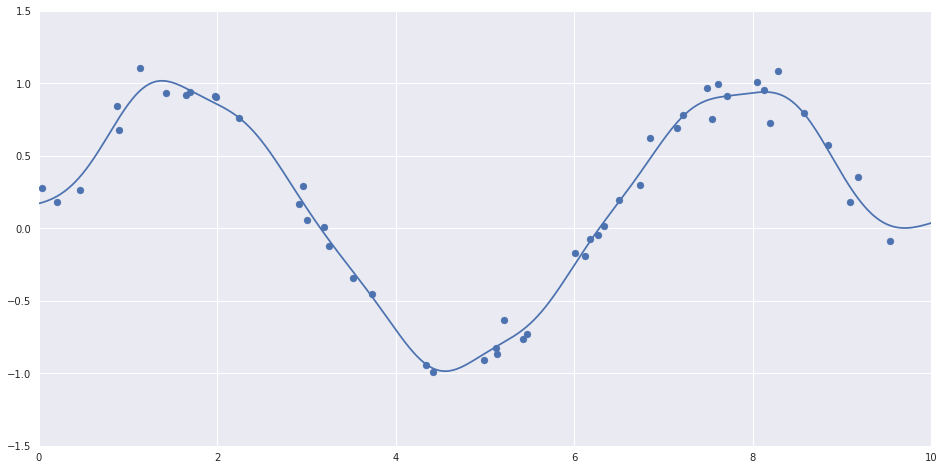

In [201]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(40), Lasso(alpha=0.001))
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

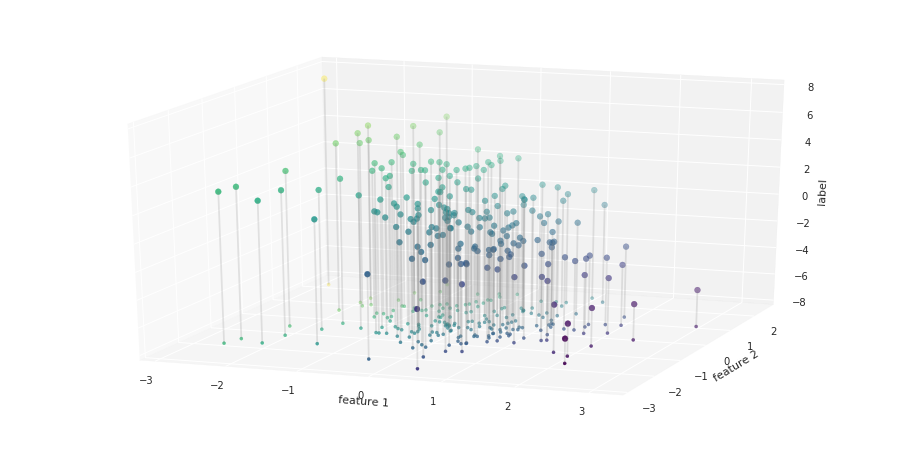

In [202]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

x_train = rng.randn(200, 2)
y_train = np.dot(x_train, [-2, 1]) + 0.1 * rng.randn(x_train.shape[0])

points = np.hstack([x_train, y_train[:, None]]).reshape(-1, 1, 3)
segments = np.hstack([points, points])
segments[:, 0, 2] = -8


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c=y_train, s=35,
           cmap='viridis')
ax.add_collection3d(Line3DCollection(segments, colors='gray', alpha=0.2))
ax.scatter(x_train[:, 0], x_train[:, 1], -8 + np.zeros(x_train.shape[0]), c=y_train, s=10,
           cmap='viridis')

# format plot
ax.patch.set_facecolor('white')
ax.view_init(elev=20, azim=-70)
ax.set_zlim3d(-8, 8)

ax.set(xlabel='feature 1', ylabel='feature 2', zlabel='label')


for tick in ax.w_xaxis.get_ticklines():
    tick.set_visible(False)
for tick in ax.w_yaxis.get_ticklines():
    tick.set_visible(False)
for tick in ax.w_zaxis.get_ticklines():
    tick.set_visible(False)


In [203]:
def format_plot(ax, title):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel('feature 1', color='gray')
    ax.set_ylabel('feature 2', color='gray')
    ax.set_title(title, color='gray')

## Example: Predicting Bicycle Traffic

In [204]:
def random_sample_df(df, size=10):
    return df.iloc[np.random.randint(1, len(df), size, dtype=int)]

In [205]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
# wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

In [206]:
import pandas as pd
import os
PATH='/home/karen/Downloads/data'
counts = pd.read_csv(os.path.join(PATH,'FremontBridge.csv'), index_col='Date', parse_dates=True)
weather = pd.read_csv(os.path.join(PATH,'BicycleWeather.csv'), index_col='DATE', parse_dates=True)

In [207]:
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2015-12-13 02:00:00,4,0
2013-12-24 04:00:00,3,3
2015-02-03 11:00:00,55,0
2014-11-17 11:00:00,47,3
2017-07-06 10:00:00,58,84
2013-07-08 20:00:00,82,83
2015-09-22 09:00:00,210,124
2015-07-29 04:00:00,8,2
2015-04-16 15:00:00,81,82


In [208]:
random_sample_df(weather, 5)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2013-06-30,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,339,172,25,300,300,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-02-13,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,156,67,17,130,130,...,-9999,-9999,1,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-04-27,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,133,61,48,210,230,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2014-05-17,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,200,117,32,190,260,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-03-09,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,36,0,0,94,50,28,230,-9999,...,-9999,-9999,1,-9999,-9999,-9999,1,-9999,-9999,-9999


In [209]:
counts['Total'] = counts.sum(axis=1) # row sum
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total
Date,,,
2014-03-05 15:00:00,30,34,64
2017-06-29 08:00:00,583,328,911
2017-09-29 16:00:00,96,199,295
2013-10-02 02:00:00,1,1,2
2013-02-27 22:00:00,6,14,20
2014-08-26 12:00:00,71,72,143
2013-10-09 01:00:00,5,0,5
2016-07-25 22:00:00,16,24,40
2013-01-03 07:00:00,108,41,149


In [210]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(7):
    counts[days[i]] = (counts.index.dayofweek == i).astype(float)

In [211]:
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,,,
2014-07-10 04:00:00,8,1,9,0,0,0,1,0,0,0
2012-11-16 11:00:00,47,26,73,0,0,0,0,1,0,0
2015-12-22 23:00:00,1,8,9,0,1,0,0,0,0,0
2014-08-01 00:00:00,11,14,25,0,0,0,0,1,0,0
2013-08-14 06:00:00,100,47,147,0,0,1,0,0,0,0
2017-06-24 13:00:00,173,88,261,0,0,0,0,0,1,0
2017-06-20 01:00:00,0,0,0,0,1,0,0,0,0,0
2015-07-30 07:00:00,271,145,416,0,0,0,1,0,0,0
2013-02-25 07:00:00,135,54,189,1,0,0,0,0,0,0


In [212]:
pd.Series(1, index=holidays, name='holiday').head()

2012-01-02    1
2012-01-16    1
2012-02-20    1
2012-05-28    1
2012-07-04    1
Name: holiday, dtype: int64

In [213]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
temp = counts[['Total']].join(pd.Series(1, index=holidays, name='holiday'))
temp['holiday'].fillna(0, inplace=True)
#daily['holiday'].isnull().unique()
counts['holiday']=temp['holiday']
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,,,
2016-12-14 07:00:00,118,72,190,0,0,1,0,0,0,0,0
2014-10-24 07:00:00,189,57,246,0,0,0,0,1,0,0,0
2014-12-04 05:00:00,19,4,23,0,0,0,1,0,0,0,0
2014-12-29 16:00:00,58,76,134,1,0,0,0,0,0,0,0
2017-04-15 03:00:00,2,1,3,0,0,0,0,0,1,0,0
2013-04-05 03:00:00,0,0,0,0,0,0,0,1,0,0,0
2013-05-06 20:00:00,64,66,130,1,0,0,0,0,0,0,0
2013-12-02 05:00:00,22,6,28,1,0,0,0,0,0,0,0
2014-05-07 17:00:00,285,573,858,0,0,1,0,0,0,0,0


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


(8, 17)

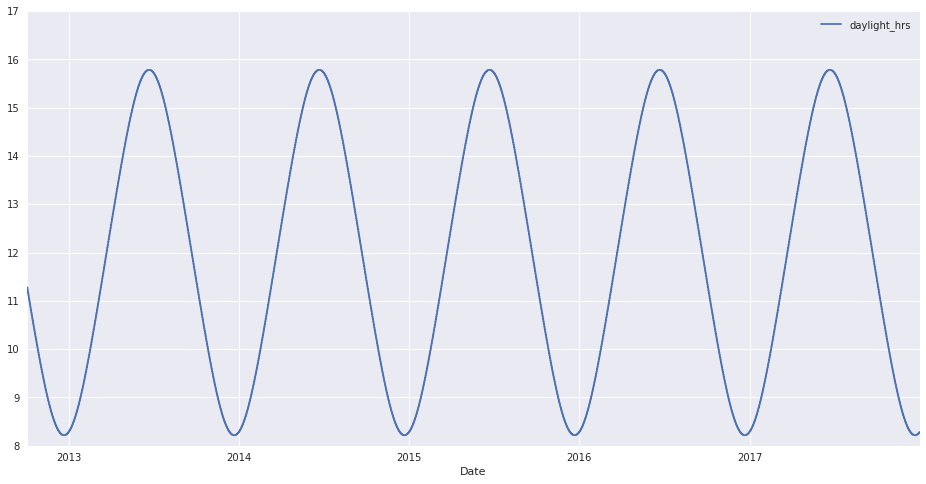

In [214]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

counts['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
counts[['daylight_hrs']].plot(figsize=(16,8))
plt.ylim(8, 17)

In [215]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

temp = counts[['Total']].join(weather[['PRCP', 'Temp (C)', 'dry day']])
random_sample_df(temp)

,Total,PRCP,Temp (C),dry day
Date,,,,
2014-07-22 17:00:00,702,NaN,NaN,NaN
2014-04-21 20:00:00,68,NaN,NaN,NaN
2016-12-29 15:00:00,71,NaN,NaN,NaN
2013-02-28 16:00:00,118,NaN,NaN,NaN
2016-03-17 05:00:00,29,NaN,NaN,NaN
2017-06-10 12:00:00,269,NaN,NaN,NaN
2016-11-16 09:00:00,230,NaN,NaN,NaN
2014-11-22 13:00:00,84,NaN,NaN,NaN
2012-11-12 04:00:00,2,NaN,NaN,NaN


In [216]:
temp['annual'] = (temp.index - temp.index[0]).days / 365.

In [217]:
counts[['PRCP', 'Temp (C)', 'dry day','annual']]=temp[['PRCP', 'Temp (C)', 'dry day','annual']]
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,,,
2015-07-15 06:00:00,147,53,200,0,0,1,0,0,0,0,0,15.436525,NaN,NaN,NaN,2.780822
2016-01-11 15:00:00,28,41,69,1,0,0,0,0,0,0,0,8.491083,NaN,NaN,NaN,3.273973
2017-06-07 19:00:00,315,113,428,0,0,1,0,0,0,0,0,15.637118,NaN,NaN,NaN,4.679452
2013-06-07 01:00:00,2,5,7,0,0,0,0,1,0,0,0,15.637118,NaN,NaN,NaN,0.676712
2013-04-22 10:00:00,63,44,107,1,0,0,0,0,0,0,0,13.765175,NaN,NaN,NaN,0.550685
2016-10-27 07:00:00,169,105,274,0,0,0,1,0,0,0,0,9.933420,NaN,NaN,NaN,4.068493
2016-07-27 13:00:00,48,47,95,0,0,1,0,0,0,0,0,14.985694,NaN,NaN,NaN,3.816438
2014-10-21 18:00:00,126,227,353,0,1,0,0,0,0,0,0,10.282679,NaN,NaN,NaN,2.049315
2014-03-04 01:00:00,2,0,2,0,1,0,0,0,0,0,0,10.915587,NaN,NaN,NaN,1.416438


In [220]:
# Drop any rows with null values
counts.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = counts[column_names]
y = counts['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
counts['predicted'] = model.predict(X)

In [221]:
random_sample_df(counts)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,,,
2012-12-06,2,2,4,0,0,0,1,0,0,0,0,8.370238,0.059055,6.65,0,0.175342,6.373532
2014-06-07,7,13,20,0,0,0,0,0,1,0,0,15.632233,0.000000,18.85,1,1.676712,25.216801
2013-10-02,8,4,12,0,0,1,0,0,0,0,0,11.350277,0.208661,11.10,0,0.997260,8.925524
2013-10-03,3,2,5,0,0,0,1,0,0,0,0,11.291930,0.031496,11.65,0,1.000000,10.050130
2013-04-25,5,3,8,0,0,0,1,0,0,0,0,13.927345,0.000000,14.20,1,0.558904,15.418059
2013-03-28,6,4,10,0,0,0,1,0,0,0,0,12.334739,0.078740,12.20,0,0.482192,11.144185
2015-02-22,6,9,15,0,0,0,0,0,0,1,0,10.337655,0.000000,7.50,1,2.389041,15.097460
2015-05-23,6,9,15,0,0,0,0,0,1,0,0,15.198876,0.000000,13.90,1,2.635616,21.720181
2013-06-20,4,8,12,0,0,0,1,0,0,0,0,15.779300,0.118110,15.00,0,0.712329,14.198361


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


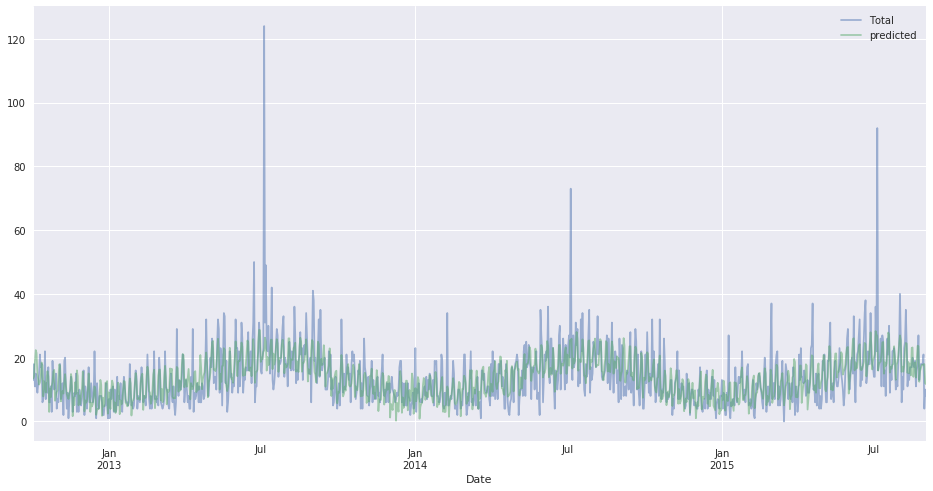

In [222]:
counts[['Total', 'predicted']].plot(alpha=0.5, figsize=(16,8));

It is evident that we have missed some key features, especially during the summer time.

Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).


In [249]:
params = pd.Series(model.coef_, index=X.columns)
abs(params).sort_values(ascending=False) # ranked on contribution to Total

Mon             5.469967
Sat             4.491504
holiday         3.761860
Sun             3.664945
Wed             3.213085
Tue             3.074720
Thu             2.972465
dry day         2.392941
Fri             1.654775
annual          0.893106
daylight_hrs    0.629522
Temp (C)        0.522309
PRCP            0.040696
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [250]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [251]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon               -5      1
Tue               -3      1
Wed               -3      1
Thu               -3      1
Fri                2      1
Sat                4      1
Sun                4      1
holiday            4      1
daylight_hrs       1      0
PRCP              -0      1
dry day            2      0
Temp (C)           1      0
annual            -1      0
